In [1]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [2]:
filename='preprocessed_data.pkl'

In [3]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [4]:
len(data)

8450

In [5]:
Y= data.iloc[:,1].values
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [6]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [7]:
X = data['Transcript'].tolist()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [10]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

6760
1690
6760
1690


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [13]:
train_tokenizer = create_tokens(X_train)

In [14]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [15]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [16]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6760, 100)
(1690, 100)
(6760,)
(1690,)


In [17]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

8741

In [18]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [20]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=2)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 20, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
model=keras.Model(seq_input,output)

In [21]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
attention_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/25
96/96 [==============================] - 8s 81ms/step - loss: 0.2802 - accuracy: 0.9270 - val_loss: 0.2288 - val_accuracy: 0.9393
Epoch 2/25
96/96 [==============================] - 7s 72ms/step - loss: 0.2260 - accuracy: 0.9369 - val_loss: 0.1844 - val_accuracy: 0.9393
Epoch 3/25
96/96 [==============================] - 7s 69ms/step - loss: 0.1183 - accuracy: 0.9602 - val_loss: 0.1224 - val_accuracy: 0.9556
Epoch 4/25
96/96 [==============================] - 7s 70ms/step - loss: 0.0614 - accuracy: 0.9799 - val_loss: 0.1281 - val_accuracy: 0.9586
Epoch 5/25
96/96 [==============================] - 7s 69ms/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.1304 - val_accuracy: 0.9586
Epoch 6/25
96/96 [==============================] - 7s 69ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.1601 - val_accuracy: 0.9527
Epoch 7/25
96/96 [==============================] - 7s 71ms/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 0.1560 - val_accuracy: 0.9601
Epoch 8/25
96

In [23]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 0s 7ms/step - loss: 0.2389 - accuracy: 0.9627


0.9627218842506409

In [24]:
def model_attention_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [25]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] units=10 ........................................................
Epoch 1/10
141/141 - 8s - loss: 0.2543 - accuracy: 0.9308
Epoch 2/10
141/141 - 8s - loss: 0.1636 - accuracy: 0.9490
Epoch 3/10
141/141 - 8s - loss: 0.0723 - accuracy: 0.9756
Epoch 4/10
141/141 - 8s - loss: 0.0449 - accuracy: 0.9845
Epoch 5/10
141/141 - 8s - loss: 0.0312 - accuracy: 0.9902
Epoch 6/10
141/141 - 9s - loss: 0.0245 - accuracy: 0.9927
Epoch 7/10
141/141 - 9s - loss: 0.0191 - accuracy: 0.9942
Epoch 8/10
141/141 - 9s - loss: 0.0121 - accuracy: 0.9956
Epoch 9/10
141/141 - 10s - loss: 0.0125 - accuracy: 0.9951
Epoch 10/10
141/141 - 9s - loss: 0.0099 - accuracy: 0.9958
71/71 - 1s - loss: 0.2205 - accuracy: 0.9587
[CV] ......................................... units=10, total= 1.5min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/10
141/141 - 8s - loss: 0.2451 - accuracy: 0.9332
Epoch 2/10
141/141 - 8s - loss: 0.1337 - accuracy: 0.9525
Epoch 3/10
141/141 - 10s - loss: 0.0578 - accuracy: 0.9800
Epoch 4/10
141/141 - 8s - loss: 0.0295 - accuracy: 0.9898
Epoch 5/10
141/141 - 10s - loss: 0.0173 - accuracy: 0.9945
Epoch 6/10
141/141 - 8s - loss: 0.0151 - accuracy: 0.9947
Epoch 7/10
141/141 - 9s - loss: 0.0115 - accuracy: 0.9962
Epoch 8/10
141/141 - 8s - loss: 0.0106 - accuracy: 0.9967
Epoch 9/10
141/141 - 8s - loss: 0.0086 - accuracy: 0.9967
Epoch 10/10
141/141 - 9s - loss: 0.0092 - accuracy: 0.9973
71/71 - 1s - loss: 0.2413 - accuracy: 0.9578
[CV] ......................................... units=10, total= 1.5min
[CV] units=10 ........................................................
Epoch 1/10
141/141 - 8s - loss: 0.2678 - accuracy: 0.9310
Epoch 2/10
141/141 - 9s - loss: 0.1901 - accuracy: 0.9394
Epoch 3/10
141/141 - 8s - loss: 0.0783 - accuracy: 0.9727
Epoch 4/10
141/141 - 8s - loss: 0.0435 - accuracy: 0.986

Epoch 7/10
141/141 - 9s - loss: 0.0163 - accuracy: 0.9947
Epoch 8/10
141/141 - 8s - loss: 0.0120 - accuracy: 0.9964
Epoch 9/10
141/141 - 8s - loss: 0.0100 - accuracy: 0.9971
Epoch 10/10
141/141 - 8s - loss: 0.0100 - accuracy: 0.9967
71/71 - 1s - loss: 0.2109 - accuracy: 0.9596
[CV] ........................................ units=128, total= 1.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 17.6min finished


Epoch 1/10
212/212 - 13s - loss: 0.2467 - accuracy: 0.9328
Epoch 2/10
212/212 - 13s - loss: 0.1104 - accuracy: 0.9608
Epoch 3/10
212/212 - 13s - loss: 0.0573 - accuracy: 0.9799
Epoch 4/10
212/212 - 13s - loss: 0.0325 - accuracy: 0.9885
Epoch 5/10
212/212 - 13s - loss: 0.0243 - accuracy: 0.9922
Epoch 6/10
212/212 - 13s - loss: 0.0198 - accuracy: 0.9936
Epoch 7/10
212/212 - 13s - loss: 0.0152 - accuracy: 0.9947
Epoch 8/10
212/212 - 13s - loss: 0.0141 - accuracy: 0.9948
Epoch 9/10
212/212 - 13s - loss: 0.0115 - accuracy: 0.9947
Epoch 10/10
212/212 - 13s - loss: 0.0095 - accuracy: 0.9963
Best accuracy:  0.9607988125385617
Best parameters:  {'units': 64}


In [26]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 5s - loss: 0.2560 - accuracy: 0.9374
Epoch 2/10
141/141 - 6s - loss: 0.1749 - accuracy: 0.9447
Epoch 3/10
141/141 - 5s - loss: 0.0788 - accuracy: 0.9754
Epoch 4/10
141/141 - 5s - loss: 0.0488 - accuracy: 0.9851
Epoch 5/10
141/141 - 6s - loss: 0.0355 - accuracy: 0.9887
Epoch 6/10
141/141 - 5s - loss: 0.0255 - accuracy: 0.9936
Epoch 7/10
141/141 - 6s - loss: 0.0194 - accuracy: 0.9945
Epoch 8/10
141/141 - 6s - loss: 0.0150 - accuracy: 0.9956
Epoch 9/10
141/141 - 5s - loss: 0.0133 - accuracy: 0.9960
Epoch 10/10
141/141 - 6s - loss: 0.0138 - accuracy: 0.9958
71/71 - 0s - loss: 0.2047 - accuracy: 0.9552
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total= 1.0min
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/10
141/141 - 5s - loss: 0.2881 - accuracy: 0.9306
Epoch 2/10
141/141 - 6s - loss: 0.1931 - accuracy: 0.9441
Epoch 3/10
141/141 - 6s - loss: 0.0877 - accuracy: 0.9698
Epoch 4/10
141/141 - 5s - loss: 0.0516 - accuracy: 0.9825
Epoch 5/10
141/141 - 6s - loss: 0.0301 - accuracy: 0.9887
Epoch 6/10
141/141 - 6s - loss: 0.0219 - accuracy: 0.9900
Epoch 7/10
141/141 - 6s - loss: 0.0164 - accuracy: 0.9920
Epoch 8/10
141/141 - 6s - loss: 0.0122 - accuracy: 0.9942
Epoch 9/10
141/141 - 5s - loss: 0.0111 - accuracy: 0.9953
Epoch 10/10
141/141 - 5s - loss: 0.0085 - accuracy: 0.9969
71/71 - 0s - loss: 0.1864 - accuracy: 0.9614
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total= 1.0min
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
141/141 - 5s - loss: 0.2706 - accuracy: 0.9294
Epoch 2/10
141/141 - 6s - loss: 0.1761 - accuracy: 0.9408
Epoch 3/10
141/141 - 6s - loss: 0.0890 - accuracy: 0.9649
Epoch 4/10
141/141 - 5s - loss: 0.0567 - accuracy: 0.9814


Epoch 10/10
141/141 - 5s - loss: 0.0065 - accuracy: 0.9978
71/71 - 0s - loss: 0.2234 - accuracy: 0.9512
[CV] ....... kernel_size=3, nb_filters=256, pool_size=4, total=  58.7s
[CV] kernel_size=5, nb_filters=128, pool_size=2 ......................
Epoch 1/10
141/141 - 6s - loss: 0.2881 - accuracy: 0.9303
Epoch 2/10
141/141 - 6s - loss: 0.1994 - accuracy: 0.9410
Epoch 3/10
141/141 - 6s - loss: 0.0933 - accuracy: 0.9683
Epoch 4/10
141/141 - 6s - loss: 0.0553 - accuracy: 0.9807
Epoch 5/10
141/141 - 6s - loss: 0.0409 - accuracy: 0.9847
Epoch 6/10
141/141 - 6s - loss: 0.0285 - accuracy: 0.9896
Epoch 7/10
141/141 - 6s - loss: 0.0214 - accuracy: 0.9916
Epoch 8/10
141/141 - 6s - loss: 0.0180 - accuracy: 0.9918
Epoch 9/10
141/141 - 6s - loss: 0.0150 - accuracy: 0.9933
Epoch 10/10
141/141 - 6s - loss: 0.0117 - accuracy: 0.9945
71/71 - 0s - loss: 0.2215 - accuracy: 0.9508
[CV] ....... kernel_size=5, nb_filters=128, pool_size=2, total= 1.1min
[CV] kernel_size=5, nb_filters=128, pool_size=2 .........

Epoch 6/10
141/141 - 6s - loss: 0.0166 - accuracy: 0.9953
Epoch 7/10
141/141 - 6s - loss: 0.0133 - accuracy: 0.9960
Epoch 8/10
141/141 - 6s - loss: 0.0118 - accuracy: 0.9969
Epoch 9/10
141/141 - 6s - loss: 0.0103 - accuracy: 0.9969
Epoch 10/10
141/141 - 6s - loss: 0.0113 - accuracy: 0.9962
71/71 - 1s - loss: 0.2042 - accuracy: 0.9583
[CV] ....... kernel_size=5, nb_filters=256, pool_size=4, total= 1.1min
[CV] kernel_size=5, nb_filters=256, pool_size=4 ......................
Epoch 1/10
141/141 - 6s - loss: 0.2549 - accuracy: 0.9306
Epoch 2/10
141/141 - 6s - loss: 0.1568 - accuracy: 0.9496
Epoch 3/10
141/141 - 6s - loss: 0.0703 - accuracy: 0.9760
Epoch 4/10
141/141 - 6s - loss: 0.0348 - accuracy: 0.9902
Epoch 5/10
141/141 - 6s - loss: 0.0225 - accuracy: 0.9929
Epoch 6/10
141/141 - 6s - loss: 0.0161 - accuracy: 0.9951
Epoch 7/10
141/141 - 6s - loss: 0.0095 - accuracy: 0.9971
Epoch 8/10
141/141 - 6s - loss: 0.0087 - accuracy: 0.9973
Epoch 9/10
141/141 - 6s - loss: 0.0054 - accuracy: 0.9980


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 25.8min finished


Epoch 1/10
212/212 - 11s - loss: 0.2238 - accuracy: 0.9388
Epoch 2/10
212/212 - 12s - loss: 0.0968 - accuracy: 0.9670
Epoch 3/10
212/212 - 12s - loss: 0.0517 - accuracy: 0.9820
Epoch 4/10
212/212 - 11s - loss: 0.0320 - accuracy: 0.9895
Epoch 5/10
212/212 - 11s - loss: 0.0224 - accuracy: 0.9920
Epoch 6/10
212/212 - 11s - loss: 0.0178 - accuracy: 0.9944
Epoch 7/10
212/212 - 12s - loss: 0.0137 - accuracy: 0.9959
Epoch 8/10
212/212 - 11s - loss: 0.0112 - accuracy: 0.9960
Epoch 9/10
212/212 - 11s - loss: 0.0083 - accuracy: 0.9966
Epoch 10/10
212/212 - 11s - loss: 0.0074 - accuracy: 0.9970
Best accuracy:  0.960355035087766
Best parameters:  {'kernel_size': 3, 'nb_filters': 256, 'pool_size': 2}


In [27]:
param_grid = {
    'neurons':[10,20,64,128]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 8s - loss: 0.2629 - accuracy: 0.9308
Epoch 2/10
141/141 - 8s - loss: 0.1619 - accuracy: 0.9483
Epoch 3/10
141/141 - 9s - loss: 0.0690 - accuracy: 0.9771
Epoch 4/10
141/141 - 8s - loss: 0.0407 - accuracy: 0.9882
Epoch 5/10
141/141 - 8s - loss: 0.0281 - accuracy: 0.9920
Epoch 6/10
141/141 - 8s - loss: 0.0208 - accuracy: 0.9940
Epoch 7/10
141/141 - 8s - loss: 0.0173 - accuracy: 0.9938
Epoch 8/10
141/141 - 8s - loss: 0.0138 - accuracy: 0.9953
Epoch 9/10
141/141 - 8s - loss: 0.0137 - accuracy: 0.9956
Epoch 10/10
141/141 - 8s - loss: 0.0119 - accuracy: 0.9956
71/71 - 1s - loss: 0.2175 - accuracy: 0.9570
[CV] ....................................... neurons=10, total= 1.5min
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/10
141/141 - 8s - loss: 0.2624 - accuracy: 0.9345
Epoch 2/10
141/141 - 8s - loss: 0.1656 - accuracy: 0.9454
Epoch 3/10
141/141 - 8s - loss: 0.0725 - accuracy: 0.9751
Epoch 4/10
141/141 - 8s - loss: 0.0361 - accuracy: 0.9885
Epoch 5/10
141/141 - 8s - loss: 0.0249 - accuracy: 0.9911
Epoch 6/10
141/141 - 8s - loss: 0.0128 - accuracy: 0.9960
Epoch 7/10
141/141 - 9s - loss: 0.0125 - accuracy: 0.9962
Epoch 8/10
141/141 - 8s - loss: 0.0092 - accuracy: 0.9962
Epoch 9/10
141/141 - 8s - loss: 0.0075 - accuracy: 0.9967
Epoch 10/10
141/141 - 8s - loss: 0.0079 - accuracy: 0.9962
71/71 - 1s - loss: 0.2174 - accuracy: 0.9605
[CV] ....................................... neurons=10, total= 1.5min
[CV] neurons=10 ......................................................
Epoch 1/10
141/141 - 8s - loss: 0.2795 - accuracy: 0.9297
Epoch 2/10
141/141 - 8s - loss: 0.1998 - accuracy: 0.9401
Epoch 3/10
141/141 - 9s - loss: 0.0900 - accuracy: 0.9718
Epoch 4/10
141/141 - 8s - loss: 0.0512 - accuracy: 0.9829


Epoch 10/10
141/141 - 8s - loss: 0.0043 - accuracy: 0.9991
71/71 - 1s - loss: 0.2102 - accuracy: 0.9649
[CV] ...................................... neurons=128, total= 1.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 18.0min finished


Epoch 1/10
212/212 - 12s - loss: 0.2192 - accuracy: 0.9351
Epoch 2/10
212/212 - 13s - loss: 0.1028 - accuracy: 0.9648
Epoch 3/10
212/212 - 13s - loss: 0.0534 - accuracy: 0.9815
Epoch 4/10
212/212 - 12s - loss: 0.0308 - accuracy: 0.9891
Epoch 5/10
212/212 - 12s - loss: 0.0195 - accuracy: 0.9933
Epoch 6/10
212/212 - 12s - loss: 0.0142 - accuracy: 0.9956
Epoch 7/10
212/212 - 13s - loss: 0.0145 - accuracy: 0.9948
Epoch 8/10
212/212 - 13s - loss: 0.0104 - accuracy: 0.9953
Epoch 9/10
212/212 - 12s - loss: 0.0094 - accuracy: 0.9959
Epoch 10/10
212/212 - 12s - loss: 0.0066 - accuracy: 0.9973
Best accuracy:  0.961686395567197
Best parameters:  {'neurons': 128}


In [28]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 8s - loss: 0.2544 - accuracy: 0.9345
Epoch 2/10
141/141 - 8s - loss: 0.1531 - accuracy: 0.9507
Epoch 3/10
141/141 - 8s - loss: 0.0729 - accuracy: 0.9729
Epoch 4/10
141/141 - 8s - loss: 0.0440 - accuracy: 0.9876
Epoch 5/10
141/141 - 8s - loss: 0.0297 - accuracy: 0.9918
Epoch 6/10
141/141 - 8s - loss: 0.0228 - accuracy: 0.9933
Epoch 7/10
141/141 - 8s - loss: 0.0190 - accuracy: 0.9942
Epoch 8/10
141/141 - 8s - loss: 0.0142 - accuracy: 0.9949
Epoch 9/10
141/141 - 9s - loss: 0.0121 - accuracy: 0.9942
Epoch 10/10
141/141 - 8s - loss: 0.0087 - accuracy: 0.9967
71/71 - 1s - loss: 0.2265 - accuracy: 0.9587
[CV] ................................. dropout_rate=0.1, total= 1.5min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/10
141/141 - 8s - loss: 0.2594 - accuracy: 0.9314
Epoch 2/10
141/141 - 9s - loss: 0.1668 - accuracy: 0.9463
Epoch 3/10
141/141 - 9s - loss: 0.0758 - accuracy: 0.9727
Epoch 4/10
141/141 - 8s - loss: 0.0390 - accuracy: 0.9869
Epoch 5/10
141/141 - 9s - loss: 0.0268 - accuracy: 0.9925
Epoch 6/10
141/141 - 8s - loss: 0.0205 - accuracy: 0.9940
Epoch 7/10
141/141 - 9s - loss: 0.0149 - accuracy: 0.9953
Epoch 8/10
141/141 - 8s - loss: 0.0140 - accuracy: 0.9953
Epoch 9/10
141/141 - 9s - loss: 0.0136 - accuracy: 0.9949
Epoch 10/10
141/141 - 9s - loss: 0.0158 - accuracy: 0.9945
71/71 - 1s - loss: 0.1953 - accuracy: 0.9574
[CV] ................................. dropout_rate=0.1, total= 1.5min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
141/141 - 8s - loss: 0.2579 - accuracy: 0.9306
Epoch 2/10
141/141 - 9s - loss: 0.1678 - accuracy: 0.9452
Epoch 3/10
141/141 - 8s - loss: 0.0852 - accuracy: 0.9745
Epoch 4/10
141/141 - 9s - loss: 0.0465 - accuracy: 0.9845


Epoch 10/10
141/141 - 8s - loss: 0.0057 - accuracy: 0.9984
71/71 - 1s - loss: 0.2213 - accuracy: 0.9578
[CV] ................................. dropout_rate=0.4, total= 1.5min
[CV] dropout_rate=0.5 ................................................
Epoch 1/10
141/141 - 8s - loss: 0.2577 - accuracy: 0.9319
Epoch 2/10
141/141 - 8s - loss: 0.1747 - accuracy: 0.9447
Epoch 3/10
141/141 - 8s - loss: 0.0801 - accuracy: 0.9738
Epoch 4/10
141/141 - 8s - loss: 0.0465 - accuracy: 0.9834
Epoch 5/10
141/141 - 8s - loss: 0.0359 - accuracy: 0.9893
Epoch 6/10
141/141 - 8s - loss: 0.0254 - accuracy: 0.9931
Epoch 7/10
141/141 - 8s - loss: 0.0216 - accuracy: 0.9925
Epoch 8/10
141/141 - 8s - loss: 0.0182 - accuracy: 0.9931
Epoch 9/10
141/141 - 8s - loss: 0.0124 - accuracy: 0.9953
Epoch 10/10
141/141 - 8s - loss: 0.0131 - accuracy: 0.9956
71/71 - 1s - loss: 0.2131 - accuracy: 0.9463
[CV] ................................. dropout_rate=0.5, total= 1.4min
[CV] dropout_rate=0.5 ...................................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 22.0min finished


Epoch 1/10
212/212 - 12s - loss: 0.2486 - accuracy: 0.9368
Epoch 2/10
212/212 - 12s - loss: 0.1143 - accuracy: 0.9608
Epoch 3/10
212/212 - 13s - loss: 0.0639 - accuracy: 0.9783
Epoch 4/10
212/212 - 13s - loss: 0.0412 - accuracy: 0.9858
Epoch 5/10
212/212 - 13s - loss: 0.0250 - accuracy: 0.9932
Epoch 6/10
212/212 - 13s - loss: 0.0193 - accuracy: 0.9942
Epoch 7/10
212/212 - 12s - loss: 0.0158 - accuracy: 0.9947
Epoch 8/10
212/212 - 13s - loss: 0.0153 - accuracy: 0.9950
Epoch 9/10
212/212 - 13s - loss: 0.0132 - accuracy: 0.9960
Epoch 10/10
212/212 - 13s - loss: 0.0126 - accuracy: 0.9957
Best accuracy:  0.9599112526199521
Best parameters:  {'dropout_rate': 0.3}


In [29]:
param_grid = {
    'batch_size':[32,64,128,256]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2, cv=2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
106/106 - 6s - loss: 0.2713 - accuracy: 0.9382
Epoch 2/10
106/106 - 7s - loss: 0.1975 - accuracy: 0.9429
Epoch 3/10
106/106 - 6s - loss: 0.0928 - accuracy: 0.9716
Epoch 4/10
106/106 - 6s - loss: 0.0615 - accuracy: 0.9796
Epoch 5/10
106/106 - 6s - loss: 0.0396 - accuracy: 0.9852
Epoch 6/10
106/106 - 7s - loss: 0.0249 - accuracy: 0.9888
Epoch 7/10
106/106 - 6s - loss: 0.0199 - accuracy: 0.9914
Epoch 8/10
106/106 - 6s - loss: 0.0131 - accuracy: 0.9947
Epoch 9/10
106/106 - 6s - loss: 0.0122 - accuracy: 0.9941
Epoch 10/10
106/106 - 6s - loss: 0.0115 - accuracy: 0.9938
106/106 - 1s - loss: 0.2275 - accuracy: 0.9524
[CV] .................................... batch_size=32, total= 1.1min
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/10
106/106 - 6s - loss: 0.2545 - accuracy: 0.9287
Epoch 2/10
106/106 - 6s - loss: 0.1722 - accuracy: 0.9453
Epoch 3/10
106/106 - 6s - loss: 0.0743 - accuracy: 0.9731
Epoch 4/10
106/106 - 6s - loss: 0.0394 - accuracy: 0.9864
Epoch 5/10
106/106 - 6s - loss: 0.0217 - accuracy: 0.9929
Epoch 6/10
106/106 - 6s - loss: 0.0112 - accuracy: 0.9959
Epoch 7/10
106/106 - 6s - loss: 0.0093 - accuracy: 0.9970
Epoch 8/10
106/106 - 6s - loss: 0.0064 - accuracy: 0.9973
Epoch 9/10
106/106 - 6s - loss: 0.0061 - accuracy: 0.9976
Epoch 10/10
106/106 - 6s - loss: 0.0047 - accuracy: 0.9991
106/106 - 1s - loss: 0.2299 - accuracy: 0.9580
[CV] .................................... batch_size=32, total= 1.1min
[CV] batch_size=64 ...................................................
Epoch 1/10
53/53 - 5s - loss: 0.2792 - accuracy: 0.9382
Epoch 2/10
53/53 - 5s - loss: 0.2303 - accuracy: 0.9382
Epoch 3/10
53/53 - 5s - loss: 0.1911 - accuracy: 0.9396
Epoch 4/10
53/53 - 5s - loss: 0.0902 - accuracy: 0.9669
Epoch 

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.0min finished


Epoch 1/10
106/106 - 10s - loss: 0.2537 - accuracy: 0.9371
Epoch 2/10
106/106 - 10s - loss: 0.1580 - accuracy: 0.9493
Epoch 3/10
106/106 - 10s - loss: 0.0761 - accuracy: 0.9706
Epoch 4/10
106/106 - 10s - loss: 0.0477 - accuracy: 0.9849
Epoch 5/10
106/106 - 9s - loss: 0.0314 - accuracy: 0.9888
Epoch 6/10
106/106 - 10s - loss: 0.0228 - accuracy: 0.9917
Epoch 7/10
106/106 - 10s - loss: 0.0153 - accuracy: 0.9954
Epoch 8/10
106/106 - 9s - loss: 0.0140 - accuracy: 0.9939
Epoch 9/10
106/106 - 10s - loss: 0.0109 - accuracy: 0.9960
Epoch 10/10
106/106 - 9s - loss: 0.0099 - accuracy: 0.9960
Best accuracy:  0.956656813621521
Best parameters:  {'batch_size': 64}


In [30]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=2)(conv1)
dropout= Dropout(0.3)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model=keras.Model(seq_input,output)

In [31]:
att_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
attention_history=att_model.fit(X_train, Y_train, epochs = 50, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/50
96/96 [==============================] - 13s 134ms/step - loss: 0.2528 - accuracy: 0.9283 - val_loss: 0.1672 - val_accuracy: 0.9393
Epoch 2/50
96/96 [==============================] - 12s 124ms/step - loss: 0.1120 - accuracy: 0.9622 - val_loss: 0.1211 - val_accuracy: 0.9615
Epoch 3/50
96/96 [==============================] - 12s 123ms/step - loss: 0.0568 - accuracy: 0.9785 - val_loss: 0.1328 - val_accuracy: 0.9601
Epoch 4/50
96/96 [==============================] - 12s 122ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.1944 - val_accuracy: 0.9571
Epoch 5/50
96/96 [==============================] - 12s 123ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.1673 - val_accuracy: 0.9601
Epoch 6/50
96/96 [==============================] - 12s 123ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.2241 - val_accuracy: 0.9467
Epoch 7/50
96/96 [==============================] - 12s 123ms/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 0.2370 - val_accuracy: 0.9556

In [33]:
score = att_model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 24ms/step - loss: 0.3995 - accuracy: 0.9538


0.9538461565971375

In [34]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

<Figure size 640x480 with 1 Axes>

In [35]:
att_model.save('attention_model.hdf5')

In [36]:
att_model.load_weights('attention_model.hdf5')

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [38]:
Y_pred = att_model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [39]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1547   43]
 [  35   65]]
precision is 0.6018518518518519
recall is  0.65
F1 score 0.625
specificity is 0.9729559748427673


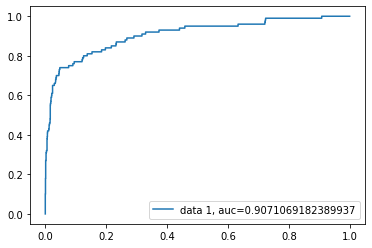

In [40]:
Y_pred_proba = att_model.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [41]:
embeddings = dict()                                 ##read glove vector file
f = open('C:/Users/HP\Desktop/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [43]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model1=keras.Model(seq_input,output)

In [46]:
att_model1.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
attention_history=att_model1.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/50
191/191 [==============================] - 9s 49ms/step - loss: 0.1850 - accuracy: 0.9405 - val_loss: 0.1436 - val_accuracy: 0.9527
Epoch 2/50
191/191 [==============================] - 9s 46ms/step - loss: 0.1184 - accuracy: 0.9607 - val_loss: 0.1449 - val_accuracy: 0.9541
Epoch 3/50
191/191 [==============================] - 9s 46ms/step - loss: 0.0931 - accuracy: 0.9675 - val_loss: 0.1066 - val_accuracy: 0.9630
Epoch 4/50
191/191 [==============================] - 9s 46ms/step - loss: 0.0737 - accuracy: 0.9755 - val_loss: 0.1278 - val_accuracy: 0.9630
Epoch 5/50
191/191 [==============================] - 10s 55ms/step - loss: 0.0591 - accuracy: 0.9781 - val_loss: 0.1199 - val_accuracy: 0.9660
Epoch 6/50
191/191 [==============================] - 10s 54ms/step - loss: 0.0484 - accuracy: 0.9837 - val_loss: 0.1107 - val_accuracy: 0.9660
Epoch 7/50
191/191 [==============================] - 10s 52ms/step - loss: 0.0505 - accuracy: 0.9816 - val_loss: 0.1278 - val_accuracy: 0.9

In [48]:
score = att_model1.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 15ms/step - loss: 0.2060 - accuracy: 0.9657


0.9656804800033569

In [49]:
def model_attention1_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [50]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
141/141 - 4s - loss: 0.2872 - accuracy: 0.9325
Epoch 2/10
141/141 - 4s - loss: 0.1792 - accuracy: 0.9374
Epoch 3/10
141/141 - 3s - loss: 0.1283 - accuracy: 0.9541
Epoch 4/10
141/141 - 3s - loss: 0.1202 - accuracy: 0.9596
Epoch 5/10
141/141 - 3s - loss: 0.1047 - accuracy: 0.9627
Epoch 6/10
141/141 - 3s - loss: 0.0945 - accuracy: 0.9665
Epoch 7/10
141/141 - 3s - loss: 0.0833 - accuracy: 0.9723
Epoch 8/10
141/141 - 4s - loss: 0.0741 - accuracy: 0.9749
Epoch 9/10
141/141 - 4s - loss: 0.0666 - accuracy: 0.9774
Epoch 10/10
141/141 - 4s - loss: 0.0599 - accuracy: 0.9805
71/71 - 0s - loss: 0.1230 - accuracy: 0.9614
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  55.3s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.2s remaining:    0.0s


Epoch 1/10
141/141 - 4s - loss: 0.2581 - accuracy: 0.9368
Epoch 2/10
141/141 - 5s - loss: 0.1757 - accuracy: 0.9381
Epoch 3/10
141/141 - 4s - loss: 0.1354 - accuracy: 0.9536
Epoch 4/10
141/141 - 4s - loss: 0.1134 - accuracy: 0.9585
Epoch 5/10
141/141 - 4s - loss: 0.1063 - accuracy: 0.9614
Epoch 6/10
141/141 - 4s - loss: 0.0916 - accuracy: 0.9665
Epoch 7/10
141/141 - 4s - loss: 0.0767 - accuracy: 0.9714
Epoch 8/10
141/141 - 4s - loss: 0.0700 - accuracy: 0.9727
Epoch 9/10
141/141 - 4s - loss: 0.0610 - accuracy: 0.9783
Epoch 10/10
141/141 - 4s - loss: 0.0562 - accuracy: 0.9798
71/71 - 1s - loss: 0.1066 - accuracy: 0.9658
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  45.9s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
141/141 - 4s - loss: 0.2586 - accuracy: 0.9361
Epoch 2/10
141/141 - 4s - loss: 0.1677 - accuracy: 0.9410
Epoch 3/10
141/141 - 4s - loss: 0.1321 - accuracy: 0.9552
Epoch 4/10
141/141 - 4s - loss: 0.1113 - accuracy: 0.9612


Epoch 10/10
141/141 - 6s - loss: 0.0540 - accuracy: 0.9829
71/71 - 2s - loss: 0.1023 - accuracy: 0.9676
[CV] ....... kernel_size=3, nb_filters=256, pool_size=4, total= 1.0min
[CV] kernel_size=5, nb_filters=128, pool_size=2 ......................
Epoch 1/10
141/141 - 5s - loss: 0.2732 - accuracy: 0.9365
Epoch 2/10
141/141 - 5s - loss: 0.1850 - accuracy: 0.9376
Epoch 3/10
141/141 - 5s - loss: 0.1359 - accuracy: 0.9525
Epoch 4/10
141/141 - 5s - loss: 0.1165 - accuracy: 0.9578
Epoch 5/10
141/141 - 5s - loss: 0.1096 - accuracy: 0.9607
Epoch 6/10
141/141 - 5s - loss: 0.0950 - accuracy: 0.9676
Epoch 7/10
141/141 - 5s - loss: 0.0871 - accuracy: 0.9727
Epoch 8/10
141/141 - 5s - loss: 0.0773 - accuracy: 0.9765
Epoch 9/10
141/141 - 5s - loss: 0.0749 - accuracy: 0.9751
Epoch 10/10
141/141 - 5s - loss: 0.0641 - accuracy: 0.9780
71/71 - 1s - loss: 0.1295 - accuracy: 0.9618
[CV] ....... kernel_size=5, nb_filters=128, pool_size=2, total=  54.6s
[CV] kernel_size=5, nb_filters=128, pool_size=2 .........

Epoch 6/10
141/141 - 6s - loss: 0.0832 - accuracy: 0.9727
Epoch 7/10
141/141 - 5s - loss: 0.0683 - accuracy: 0.9758
Epoch 8/10
141/141 - 6s - loss: 0.0582 - accuracy: 0.9803
Epoch 9/10
141/141 - 6s - loss: 0.0475 - accuracy: 0.9842
Epoch 10/10
141/141 - 5s - loss: 0.0439 - accuracy: 0.9849
71/71 - 1s - loss: 0.1135 - accuracy: 0.9636
[CV] ....... kernel_size=5, nb_filters=256, pool_size=4, total=  59.6s
[CV] kernel_size=5, nb_filters=256, pool_size=4 ......................
Epoch 1/10
141/141 - 6s - loss: 0.2344 - accuracy: 0.9330
Epoch 2/10
141/141 - 5s - loss: 0.1461 - accuracy: 0.9494
Epoch 3/10
141/141 - 5s - loss: 0.1099 - accuracy: 0.9612
Epoch 4/10
141/141 - 5s - loss: 0.0980 - accuracy: 0.9645
Epoch 5/10
141/141 - 5s - loss: 0.0872 - accuracy: 0.9698
Epoch 6/10
141/141 - 5s - loss: 0.0717 - accuracy: 0.9758
Epoch 7/10
141/141 - 5s - loss: 0.0602 - accuracy: 0.9803
Epoch 8/10
141/141 - 5s - loss: 0.0596 - accuracy: 0.9820
Epoch 9/10
141/141 - 5s - loss: 0.0497 - accuracy: 0.9822


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 22.3min finished


Epoch 1/10
212/212 - 4s - loss: 0.2506 - accuracy: 0.9318
Epoch 2/10
212/212 - 4s - loss: 0.1387 - accuracy: 0.9493
Epoch 3/10
212/212 - 4s - loss: 0.1168 - accuracy: 0.9609
Epoch 4/10
212/212 - 4s - loss: 0.1059 - accuracy: 0.9643
Epoch 5/10
212/212 - 4s - loss: 0.0899 - accuracy: 0.9694
Epoch 6/10
212/212 - 4s - loss: 0.0796 - accuracy: 0.9735
Epoch 7/10
212/212 - 4s - loss: 0.0692 - accuracy: 0.9780
Epoch 8/10
212/212 - 4s - loss: 0.0664 - accuracy: 0.9784
Epoch 9/10
212/212 - 4s - loss: 0.0558 - accuracy: 0.9828
Epoch 10/10
212/212 - 4s - loss: 0.0538 - accuracy: 0.9808
Best accuracy:  0.9676035692088703
Best parameters:  {'kernel_size': 3, 'nb_filters': 128, 'pool_size': 4}


In [51]:
param_grid = {
    'neurons':[10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 6s - loss: 0.2745 - accuracy: 0.9305
Epoch 2/10
141/141 - 7s - loss: 0.1665 - accuracy: 0.9436
Epoch 3/10
141/141 - 7s - loss: 0.1237 - accuracy: 0.9561
Epoch 4/10
141/141 - 7s - loss: 0.1002 - accuracy: 0.9672
Epoch 5/10
141/141 - 7s - loss: 0.0966 - accuracy: 0.9698
Epoch 6/10
141/141 - 6s - loss: 0.0821 - accuracy: 0.9747
Epoch 7/10
141/141 - 7s - loss: 0.0639 - accuracy: 0.9785
Epoch 8/10
141/141 - 7s - loss: 0.0568 - accuracy: 0.9816
Epoch 9/10
141/141 - 7s - loss: 0.0495 - accuracy: 0.9849
Epoch 10/10
141/141 - 7s - loss: 0.0435 - accuracy: 0.9867
71/71 - 1s - loss: 0.1494 - accuracy: 0.9636
[CV] ....................................... neurons=10, total= 1.2min
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/10
141/141 - 8s - loss: 0.2703 - accuracy: 0.9272
Epoch 2/10
141/141 - 9s - loss: 0.1678 - accuracy: 0.9396
Epoch 3/10
141/141 - 8s - loss: 0.1523 - accuracy: 0.9436
Epoch 4/10
141/141 - 9s - loss: 0.1347 - accuracy: 0.9527
Epoch 5/10
141/141 - 9s - loss: 0.1196 - accuracy: 0.9570
Epoch 6/10
141/141 - 9s - loss: 0.1097 - accuracy: 0.9629
Epoch 7/10
141/141 - 9s - loss: 0.1046 - accuracy: 0.9623
Epoch 8/10
141/141 - 8s - loss: 0.0900 - accuracy: 0.9698
Epoch 9/10
141/141 - 8s - loss: 0.0790 - accuracy: 0.9738
Epoch 10/10
141/141 - 10s - loss: 0.0716 - accuracy: 0.9776
71/71 - 1s - loss: 0.1137 - accuracy: 0.9672
[CV] ....................................... neurons=10, total= 1.6min
[CV] neurons=10 ......................................................
Epoch 1/10
141/141 - 8s - loss: 0.2658 - accuracy: 0.9363
Epoch 2/10
141/141 - 9s - loss: 0.2032 - accuracy: 0.9363
Epoch 3/10
141/141 - 8s - loss: 0.1403 - accuracy: 0.9530
Epoch 4/10
141/141 - 8s - loss: 0.1131 - accuracy: 0.9618

Epoch 10/10
141/141 - 7s - loss: 0.0418 - accuracy: 0.9854
71/71 - 1s - loss: 0.1476 - accuracy: 0.9574
[CV] ...................................... neurons=128, total= 1.3min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 16.6min finished


Epoch 1/10
212/212 - 13s - loss: 0.2224 - accuracy: 0.9368
Epoch 2/10
212/212 - 13s - loss: 0.1345 - accuracy: 0.9488
Epoch 3/10
212/212 - 13s - loss: 0.1128 - accuracy: 0.9617
Epoch 4/10
212/212 - 13s - loss: 0.0994 - accuracy: 0.9664
Epoch 5/10
212/212 - 13s - loss: 0.0895 - accuracy: 0.9694
Epoch 6/10
212/212 - 13s - loss: 0.0758 - accuracy: 0.9753
Epoch 7/10
212/212 - 13s - loss: 0.0623 - accuracy: 0.9791
Epoch 8/10
212/212 - 13s - loss: 0.0529 - accuracy: 0.9803
Epoch 9/10
212/212 - 13s - loss: 0.0522 - accuracy: 0.9800
Epoch 10/10
212/212 - 13s - loss: 0.0446 - accuracy: 0.9848
Best accuracy:  0.9656804930793463
Best parameters:  {'neurons': 20}


In [52]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 7s - loss: 0.2435 - accuracy: 0.9365
Epoch 2/10
141/141 - 8s - loss: 0.1554 - accuracy: 0.9427
Epoch 3/10
141/141 - 8s - loss: 0.1187 - accuracy: 0.9569
Epoch 4/10
141/141 - 8s - loss: 0.1001 - accuracy: 0.9669
Epoch 5/10
141/141 - 8s - loss: 0.0859 - accuracy: 0.9718
Epoch 6/10
141/141 - 8s - loss: 0.0841 - accuracy: 0.9729
Epoch 7/10
141/141 - 8s - loss: 0.0672 - accuracy: 0.9796
Epoch 8/10
141/141 - 8s - loss: 0.0632 - accuracy: 0.9800
Epoch 9/10
141/141 - 8s - loss: 0.0481 - accuracy: 0.9851
Epoch 10/10
141/141 - 8s - loss: 0.0480 - accuracy: 0.9871
71/71 - 1s - loss: 0.1228 - accuracy: 0.9596
[CV] ................................. dropout_rate=0.1, total= 1.5min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/10
141/141 - 8s - loss: 0.2820 - accuracy: 0.9319
Epoch 2/10
141/141 - 8s - loss: 0.1892 - accuracy: 0.9399
Epoch 3/10
141/141 - 8s - loss: 0.1565 - accuracy: 0.9394
Epoch 4/10
141/141 - 8s - loss: 0.1374 - accuracy: 0.9481
Epoch 5/10
141/141 - 8s - loss: 0.1258 - accuracy: 0.9561
Epoch 6/10
141/141 - 8s - loss: 0.1180 - accuracy: 0.9581
Epoch 7/10
141/141 - 8s - loss: 0.1051 - accuracy: 0.9618
Epoch 8/10
141/141 - 8s - loss: 0.0899 - accuracy: 0.9714
Epoch 9/10
141/141 - 8s - loss: 0.0845 - accuracy: 0.9678
Epoch 10/10
141/141 - 8s - loss: 0.0749 - accuracy: 0.9751
71/71 - 1s - loss: 0.1146 - accuracy: 0.9667
[CV] ................................. dropout_rate=0.1, total= 1.4min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
141/141 - 7s - loss: 0.2459 - accuracy: 0.9350
Epoch 2/10
141/141 - 8s - loss: 0.1560 - accuracy: 0.9463
Epoch 3/10
141/141 - 8s - loss: 0.1277 - accuracy: 0.9594
Epoch 4/10
141/141 - 8s - loss: 0.1079 - accuracy: 0.9645


Epoch 10/10
141/141 - 7s - loss: 0.0500 - accuracy: 0.9831
71/71 - 1s - loss: 0.1412 - accuracy: 0.9680
[CV] ................................. dropout_rate=0.4, total= 1.2min
[CV] dropout_rate=0.5 ................................................
Epoch 1/10
141/141 - 8s - loss: 0.2388 - accuracy: 0.9374
Epoch 2/10
141/141 - 9s - loss: 0.1512 - accuracy: 0.9439
Epoch 3/10
141/141 - 9s - loss: 0.1172 - accuracy: 0.9596
Epoch 4/10
141/141 - 9s - loss: 0.1066 - accuracy: 0.9669
Epoch 5/10
141/141 - 9s - loss: 0.0905 - accuracy: 0.9711
Epoch 6/10
141/141 - 8s - loss: 0.0920 - accuracy: 0.9700
Epoch 7/10
141/141 - 9s - loss: 0.0726 - accuracy: 0.9785
Epoch 8/10
141/141 - 8s - loss: 0.0703 - accuracy: 0.9760
Epoch 9/10
141/141 - 9s - loss: 0.0565 - accuracy: 0.9836
Epoch 10/10
141/141 - 9s - loss: 0.0499 - accuracy: 0.9845
71/71 - 1s - loss: 0.1430 - accuracy: 0.9552
[CV] ................................. dropout_rate=0.5, total= 1.6min
[CV] dropout_rate=0.5 ...................................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 21.4min finished


Epoch 1/10
212/212 - 12s - loss: 0.2364 - accuracy: 0.9337
Epoch 2/10
212/212 - 12s - loss: 0.1477 - accuracy: 0.9482
Epoch 3/10
212/212 - 12s - loss: 0.1212 - accuracy: 0.9611
Epoch 4/10
212/212 - 12s - loss: 0.1011 - accuracy: 0.9654
Epoch 5/10
212/212 - 12s - loss: 0.0937 - accuracy: 0.9688
Epoch 6/10
212/212 - 12s - loss: 0.0834 - accuracy: 0.9722
Epoch 7/10
212/212 - 12s - loss: 0.0726 - accuracy: 0.9749
Epoch 8/10
212/212 - 12s - loss: 0.0676 - accuracy: 0.9775
Epoch 9/10
212/212 - 12s - loss: 0.0598 - accuracy: 0.9809
Epoch 10/10
212/212 - 12s - loss: 0.0497 - accuracy: 0.9840
Best accuracy:  0.9646449758456304
Best parameters:  {'dropout_rate': 0.2}


In [53]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
141/141 - 7s - loss: 0.2624 - accuracy: 0.9361
Epoch 2/10
141/141 - 7s - loss: 0.1641 - accuracy: 0.9434
Epoch 3/10
141/141 - 8s - loss: 0.1288 - accuracy: 0.9545
Epoch 4/10
141/141 - 7s - loss: 0.1111 - accuracy: 0.9618
Epoch 5/10
141/141 - 8s - loss: 0.1030 - accuracy: 0.9652
Epoch 6/10
141/141 - 7s - loss: 0.0988 - accuracy: 0.9678
Epoch 7/10
141/141 - 8s - loss: 0.0802 - accuracy: 0.9743
Epoch 8/10
141/141 - 7s - loss: 0.0758 - accuracy: 0.9740
Epoch 9/10
141/141 - 8s - loss: 0.0680 - accuracy: 0.9802
Epoch 10/10
141/141 - 8s - loss: 0.0581 - accuracy: 0.9838
71/71 - 1s - loss: 0.1243 - accuracy: 0.9623
[CV] ......................................... units=10, total= 1.3min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/10
141/141 - 7s - loss: 0.2478 - accuracy: 0.9377
Epoch 2/10
141/141 - 7s - loss: 0.1674 - accuracy: 0.9377
Epoch 3/10
141/141 - 7s - loss: 0.1385 - accuracy: 0.9485
Epoch 4/10
141/141 - 7s - loss: 0.1220 - accuracy: 0.9585
Epoch 5/10
141/141 - 7s - loss: 0.1006 - accuracy: 0.9665
Epoch 6/10
141/141 - 7s - loss: 0.0829 - accuracy: 0.9698
Epoch 7/10
141/141 - 7s - loss: 0.0748 - accuracy: 0.9729
Epoch 8/10
141/141 - 7s - loss: 0.0666 - accuracy: 0.9758
Epoch 9/10
141/141 - 7s - loss: 0.0602 - accuracy: 0.9774
Epoch 10/10
141/141 - 7s - loss: 0.0507 - accuracy: 0.9829
71/71 - 1s - loss: 0.1086 - accuracy: 0.9698
[CV] ......................................... units=10, total= 1.3min
[CV] units=10 ........................................................
Epoch 1/10
141/141 - 8s - loss: 0.2541 - accuracy: 0.9361
Epoch 2/10
141/141 - 8s - loss: 0.1663 - accuracy: 0.9405
Epoch 3/10
141/141 - 9s - loss: 0.1314 - accuracy: 0.9563
Epoch 4/10
141/141 - 8s - loss: 0.1088 - accuracy: 0.9665


Epoch 10/10
141/141 - 14s - loss: 0.0505 - accuracy: 0.9836
71/71 - 2s - loss: 0.1223 - accuracy: 0.9609
[CV] ........................................ units=128, total= 2.2min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 20.1min finished


Epoch 1/10
212/212 - 19s - loss: 0.2424 - accuracy: 0.9318
Epoch 2/10
212/212 - 19s - loss: 0.1431 - accuracy: 0.9488
Epoch 3/10
212/212 - 18s - loss: 0.1285 - accuracy: 0.9572
Epoch 4/10
212/212 - 19s - loss: 0.1227 - accuracy: 0.9586
Epoch 5/10
212/212 - 20s - loss: 0.1104 - accuracy: 0.9633
Epoch 6/10
212/212 - 20s - loss: 0.0984 - accuracy: 0.9678
Epoch 7/10
212/212 - 19s - loss: 0.0868 - accuracy: 0.9720
Epoch 8/10
212/212 - 19s - loss: 0.0826 - accuracy: 0.9725
Epoch 9/10
212/212 - 19s - loss: 0.0717 - accuracy: 0.9780
Epoch 10/10
212/212 - 19s - loss: 0.0658 - accuracy: 0.9791
Best accuracy:  0.9661242815781628
Best parameters:  {'units': 64}


In [54]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.2)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 20, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model2=keras.Model(seq_input,output)

In [55]:
att_model2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [56]:
attention_history=att_model2.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/50
191/191 [==============================] - 12s 62ms/step - loss: 0.1860 - accuracy: 0.9453 - val_loss: 0.1187 - val_accuracy: 0.9586
Epoch 2/50
191/191 [==============================] - 9s 49ms/step - loss: 0.1119 - accuracy: 0.9638 - val_loss: 0.1147 - val_accuracy: 0.9615
Epoch 3/50
191/191 [==============================] - 10s 54ms/step - loss: 0.0855 - accuracy: 0.9719 - val_loss: 0.1024 - val_accuracy: 0.9645
Epoch 4/50
191/191 [==============================] - 10s 52ms/step - loss: 0.0681 - accuracy: 0.9775 - val_loss: 0.0918 - val_accuracy: 0.9645
Epoch 5/50
191/191 [==============================] - 10s 52ms/step - loss: 0.0524 - accuracy: 0.9831 - val_loss: 0.0889 - val_accuracy: 0.9719
Epoch 6/50
191/191 [==============================] - 11s 59ms/step - loss: 0.0480 - accuracy: 0.9842 - val_loss: 0.1232 - val_accuracy: 0.9704
Epoch 7/50
191/191 [==============================] - 10s 51ms/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 0.1104 - val_accuracy: 

In [57]:
score = att_model2.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 22ms/step - loss: 0.2692 - accuracy: 0.9675


0.9674556255340576

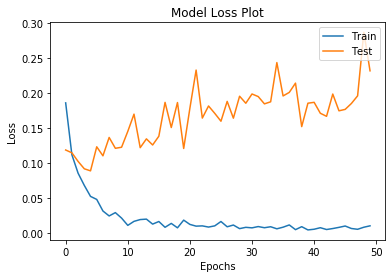

In [58]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [59]:
att_model2.save('attention_pretrained.hdf5')

In [60]:
att_model2.load_weights('attention_pretrained.hdf5')

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [62]:
Y_pred = att_model2.predict(X_test)
Y_pred = (Y_pred >0.5)

In [63]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1585    5]
 [  50   50]]
precision is 0.9090909090909091
recall is  0.5
F1 score 0.6451612903225806
specificity is 0.9968553459119497


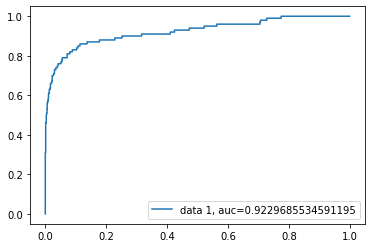

In [64]:
Y_pred_proba = att_model2.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()